In [ ]:
##imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import folium
import geopy
import numpy as np
%matplotlib inline

# Data Cleaning

In [ ]:
##load data into df
url = "https://github.com/tlena43/DataVis/blob/main/Rent_Board_Housing_Inventory_20250408.csv?raw=true"
trueList = ["Yes", "Y"]
falseList = ["No", "N"]

rent = pd.read_csv(url,
                   true_values = trueList,
                   false_values = falseList,
                   dtype={"base_rent_includes_water" : bool, "base_rent_includes_electricity" : bool,
                            "base_rent_includes_natural_gas" : bool, "base_rent_includes_refuse_recycling" : bool})

rent.head()

,unique_id,block_num,unit_count,case_type_name,submission_year,block_address,occupancy_type,occupancy_or_vacancy_date,occupancy_or_vacancy_date_year,bedroom_count,...,past_occupancy,vacancy_date,signature_date,occupancy_or_vacancy_date_history,year_property_built,point,analysis_neighborhood,supervisor_district,data_as_of,data_loaded_at
0,1820702912023306897,4714,156,Housing Inventory - Unit information (2022),2022,0 Block of NAVY RD,Vacant,NaN,NaN,Two-Bedroom,...,True,NaN,2022/06/29,"[\n {\n ""date_range_type"": ""Occupied"",\n ...",1900.0,POINT (-122.379400598 37.729485615),Bayview Hunters Point,10.0,2025/04/08 01:30:51 AM,2025/04/08 06:08:00 AM
1,-5527015774265793949,4714,156,Housing Inventory - Unit information (2022),2022,0 Block of NAVY RD,Occupied by non-owner,2012/01/18,2012,Three-Bedroom,...,False,NaN,2022/06/29,NaN,1900.0,POINT (-122.379400598 37.729485615),Bayview Hunters Point,10.0,2025/04/08 01:30:51 AM,2025/04/08 06:08:00 AM
2,-3893596051579734694,4714,156,Housing Inventory - Unit information (2022),2022,1100 Block of OAKDALE AVE,Vacant,NaN,NaN,Studio,...,True,NaN,2022/06/29,"[\n {\n ""date_range_type"": ""Occupied"",\n ...",1900.0,POINT (-122.382100107 37.729969728),Bayview Hunters Point,10.0,2025/04/08 01:30:51 AM,2025/04/08 06:08:00 AM
3,8082781840214723380,4714,156,Housing Inventory - Unit information (2022),2022,400 Block of ELLIS ST,Vacant,NaN,NaN,One-Bedroom,...,False,NaN,2022/06/29,NaN,1900.0,POINT (-122.413615228 37.784807417),Tenderloin,5.0,2025/04/08 01:30:51 AM,2025/04/08 06:08:00 AM
4,2041616970399500228,4714,156,Housing Inventory - Unit information (2022),2022,1200 Block of INGALLS ST,Vacant,NaN,NaN,One-Bedroom,...,True,NaN,2022/06/29,"[\n {\n ""date_range_type"": ""Occupied"",\n ...",1900.0,POINT (-122.380619835 37.730450613),Bayview Hunters Point,10.0,2025/04/08 01:30:51 AM,2025/04/08 06:08:00 AM


In [ ]:
##drop irrelevant columns
rent = rent.drop(columns=["unique_id", "case_type_name", "submission_year", "occupancy_or_vacancy_date", "signature_date", "occupancy_or_vacancy_date_history", "data_as_of", "data_loaded_at", "block_num", "block_address",
                          "base_rent_includes_other_utilities", "unit_count", "occupancy_type", "occupancy_or_vacancy_date_year", "vacancy_date", "past_occupancy"], axis=1)

In [ ]:
##rename for conciseness
rent = rent.rename(columns={"base_rent_includes_water" : "includes_water", "base_rent_includes_electricity" : "includes_electricity",
                            "base_rent_includes_natural_gas" : "includes_natural_gas", "base_rent_includes_refuse_recycling" : "includes_refuse_recycling"})

In [ ]:
##drop NA values for rent since we will focus on rent
rent = rent.dropna(subset="monthly_rent")

In [ ]:
##used for cleaning, now irrelevant
##commented out for cleanliness
##rent["bedroom_count"].unique()
##rent["bathroom_count"].unique()
##rent['monthly_rent'].unique()
##rent['square_footage'].unique()

In [ ]:
##map bedrooms to ints
def mapBed(x):
  if x == "One-Bedroom" or x == "One-bedroom" or x == "1 bedroom" or x == "1" or x == "1A" or x == "1U" or x == "1T" or x == "One Bedroom":
    return 1
  if x == "Two-Bedroom" or x == "Two-bedroom" or x == "2 bedroom" or x == "2" or x == "2A" or x == "2AH" or x == "2S" or x == "2U" or x == "2T" or x == "Two Bedroom":
    return 2
  if x == "Three-Bedroom" or x == "3 bedroom" or x == "3":
    return 3
  if x == "Four-Bedroom":
    return 4
  if x == "Studio" or x == "studio" or x == "0" or x == "0A" or x == "0AH" or x == "0U" or x == "Zero -(Studio)" or x == "Zero-(Studio)" or x == "Studio (sm)":
    return 0.75
  if x == "5+" or x == "Five-Bedroom":
    return 5
  if x == "Vacant":
    return None

rent["bedroom_count"] = rent["bedroom_count"].map(mapBed)

In [ ]:
##map bathrooms to ints
def mapBath(x):
  if x == "One bathroom" or x == "1 bathroom" or x == "1bathroom" or x == "1" or x == "One-Bathroom" or x == "One Bathroom" or x == "1.00":
    return 1
  if x == "One and a half bathrooms" or x == "One and a half bathdrooms":
    return 1.5
  if x == "Two bathrooms" or x == "2 bathroom" or x == "2 batroom" or x == "2  bathroom" or x == "Two-Bathroom" or x == "Two Bathroom" or x == "2" or x == "2.00":
    return 2
  if x == "Two and a half bathrooms" or x == "2.5":
    return 2.5
  if x == "Three bathrooms or more":
    return 3
  if x == "Shared bathroom facilities with other units" or x == "shared bathroom facilities with other units":
    return 0.5
  if x == "0":
    return 0
  if x == "1 bedroom" or x == "2 bedroom":
    return None

rent["bathroom_count"] = rent["bathroom_count"].map(mapBath)

In [ ]:
#map monthly rent to int
def filter_rent(x):
  temp_rent = re.sub(r"[$+,]", "", x)

  if temp_rent == "0 (no rent paid by the occupant)":
    return 0

  if "-" in temp_rent:
    temp_rent = temp_rent.split("-")
    min_rent = pd.to_numeric(temp_rent[0])
    max_rent = pd.to_numeric(temp_rent[1])
    median_rent = max_rent - ((max_rent - min_rent)/2)
    return median_rent

  if isinstance(temp_rent, str):
    return 0

  return int(temp_rent)

rent['monthly_rent'] = rent['monthly_rent'].map(filter_rent)

In [ ]:
##map square footage to int
def filter_footage(x):
  if isinstance(x, float):
    return 0

  if x == "Unknown":
    return 0

  temp_footage = re.sub(r"[$,+Sq.Fteb]", "", x)

  if temp_footage == "14-Feb-1904": #hard coding this one
    return 0

  if "-" in temp_footage:
    temp_footage = temp_footage.split(" ")[0].split("-")
    temp_footage[1] = re.sub(r"[Sq.Fft]", "", temp_footage[1])
    min_footage = pd.to_numeric(temp_footage[0])
    max_footage = pd.to_numeric(temp_footage[1])
    median_footage = max_footage - ((max_footage - min_footage)/2)
    return median_footage

  return int(temp_footage)

rent['square_footage'] = rent['square_footage'].map(filter_footage)

In [ ]:
##map point to longitude and latitude
longitude = list()
latitude = list()

for n in range(len(rent)):
  point = rent['point'].iloc[n]
  temp_point = re.sub(r"[POINT()]", "", point)
  temp_point = temp_point.split(" ")
  latitude.append(temp_point[1])
  longitude.append(temp_point[2])

rent['longitude'] = pd.Series(longitude)
rent['latitude'] = pd.Series(latitude)

rent = rent.drop(columns=['point'], axis=1)

In [ ]:
##match neighborhood categories to geojson
def match_neighborhoods(x):
  if x == "Bayview Hunters Point":
    return "Bayview"
  if x == 'Financial District/South Beach':
    return "Financial District"
  if x == 'Oceanview/Merced/Ingleside':
    return "Ocean View"
  if x == "Hayes Valley" or x == "Japantown":
    return "Western Addition"
  if x == "Tenderloin":
    return "Downtown/Civic Center"
  if x == "Lone Mountain/USF":
    return "Inner Richmond"
  if x == "Mission Bay":
    return "South of Market"
  if x == "Portola":
    return "Excelsior"
  if x == "Lincoln Park":
    return "Seacliff"
  else:
    return x

rent['analysis_neighborhood'] = rent["analysis_neighborhood"].map(match_neighborhoods)

In [ ]:
#drop na values from columns of interest
rent = rent.dropna(subset=["bedroom_count", "bathroom_count", "square_footage", "monthly_rent", "analysis_neighborhood", "supervisor_district", "year_property_built"])

In [ ]:
#create a cost per square foot column
rent["Cost per SqFt"] = rent["monthly_rent"] / rent["square_footage"]
rent = rent.replace([np.inf, -np.inf], np.nan)

In [ ]:
##cleaned dataframe
rent.head()

,bedroom_count,bathroom_count,square_footage,monthly_rent,includes_water,includes_natural_gas,includes_electricity,includes_refuse_recycling,year_property_built,analysis_neighborhood,supervisor_district,longitude,latitude,Cost per SqFt
1,3.0,1.5,1125.5,750.5,True,False,False,True,1900.0,Bayview,10.0,37.729485615,-122.379400598,0.666815
7,4.0,1.5,1375.5,375.5,True,False,False,True,1900.0,Bayview,10.0,37.730450613,-122.380619835,0.272992
8,4.0,1.5,1375.5,375.5,True,False,False,True,1900.0,Bayview,10.0,37.730450613,-122.380619835,0.272992
9,3.0,1.5,1125.5,375.5,True,False,False,True,1900.0,Bayview,10.0,37.730450613,-122.380619835,0.333629
10,2.0,1.0,875.5,1125.5,True,False,False,True,1900.0,Bayview,10.0,37.730450613,-122.380619835,1.285551


# Exploratory Graphing

In [ ]:
##handle geo json
sf_geo = "https://raw.githubusercontent.com/tlena43/DataVis/refs/heads/main/SF-neighbourhoods.geojson"

import urllib.request, json
with urllib.request.urlopen(sf_geo) as url:
    data = json.load(url)

##add mean rent to geojson
for feature in data["features"]:
  neighborhood = feature["properties"]["name"]
  mean_rent = rent[rent["analysis_neighborhood"] == neighborhood].monthly_rent.mean()
  feature["properties"]["rent"] = int(mean_rent)

In [ ]:
##pivot to isolate neighborhoods
wide =rent.pivot(columns="analysis_neighborhood", values="monthly_rent")

In [ ]:
##create choropleth of mean rent
SF_map = folium.Map(location=[37.7749, -122.4194], zoom_start=13)

choro = folium.Choropleth(
    geo_data=data,
    name='Choropleth',
    data = wide.mean(),
    columns=['analysis_neighborhood','monthly_rent'],
    key_on='feature.properties.name',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Average Rent in SF',
).add_to(SF_map)

folium.GeoJson(
    data,
    tooltip=folium.GeoJsonTooltip(fields=['name', 'rent'], aliases=['Region Name:', "Average Rent:"])
).add_to(SF_map)

SF_map

In [ ]:
rent.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155643 entries, 1 to 186843
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   bedroom_count              155643 non-null  float64
 1   bathroom_count             155643 non-null  float64
 2   square_footage             155643 non-null  float64
 3   monthly_rent               155643 non-null  float64
 4   includes_water             155643 non-null  bool   
 5   includes_natural_gas       155643 non-null  bool   
 6   includes_electricity       155643 non-null  bool   
 7   includes_refuse_recycling  155643 non-null  bool   
 8   year_property_built        155643 non-null  float64
 9   analysis_neighborhood      155643 non-null  object 
 10  supervisor_district        155643 non-null  float64
 11  longitude                  134492 non-null  object 
 12  latitude                   134492 non-null  object 
 13  Cost per SqFt              152516 

In [ ]:
rent.describe()

,bedroom_count,bathroom_count,square_footage,monthly_rent,year_property_built,supervisor_district,Cost per SqFt
count,155643.000000,155643.000000,155643.000000,155643.000000,155643.000000,155643.000000,152516.000000
mean,1.324989,1.120719,694.000366,2337.765422,1937.706264,4.727215,3.901499
std,0.722462,0.384138,389.313975,1219.722052,31.837614,2.633727,2.575584
min,0.750000,0.000000,0.000000,0.000000,1851.000000,1.000000,0.000000
25%,0.750000,1.000000,375.500000,1375.500000,1911.000000,3.000000,2.598721
50%,1.000000,1.000000,625.500000,2125.500000,1926.000000,5.000000,3.663116
75%,2.000000,1.000000,875.500000,3125.500000,1963.000000,7.000000,4.712164
max,5.000000,3.000000,4001.000000,6875.500000,2022.000000,11.000000,55.004000


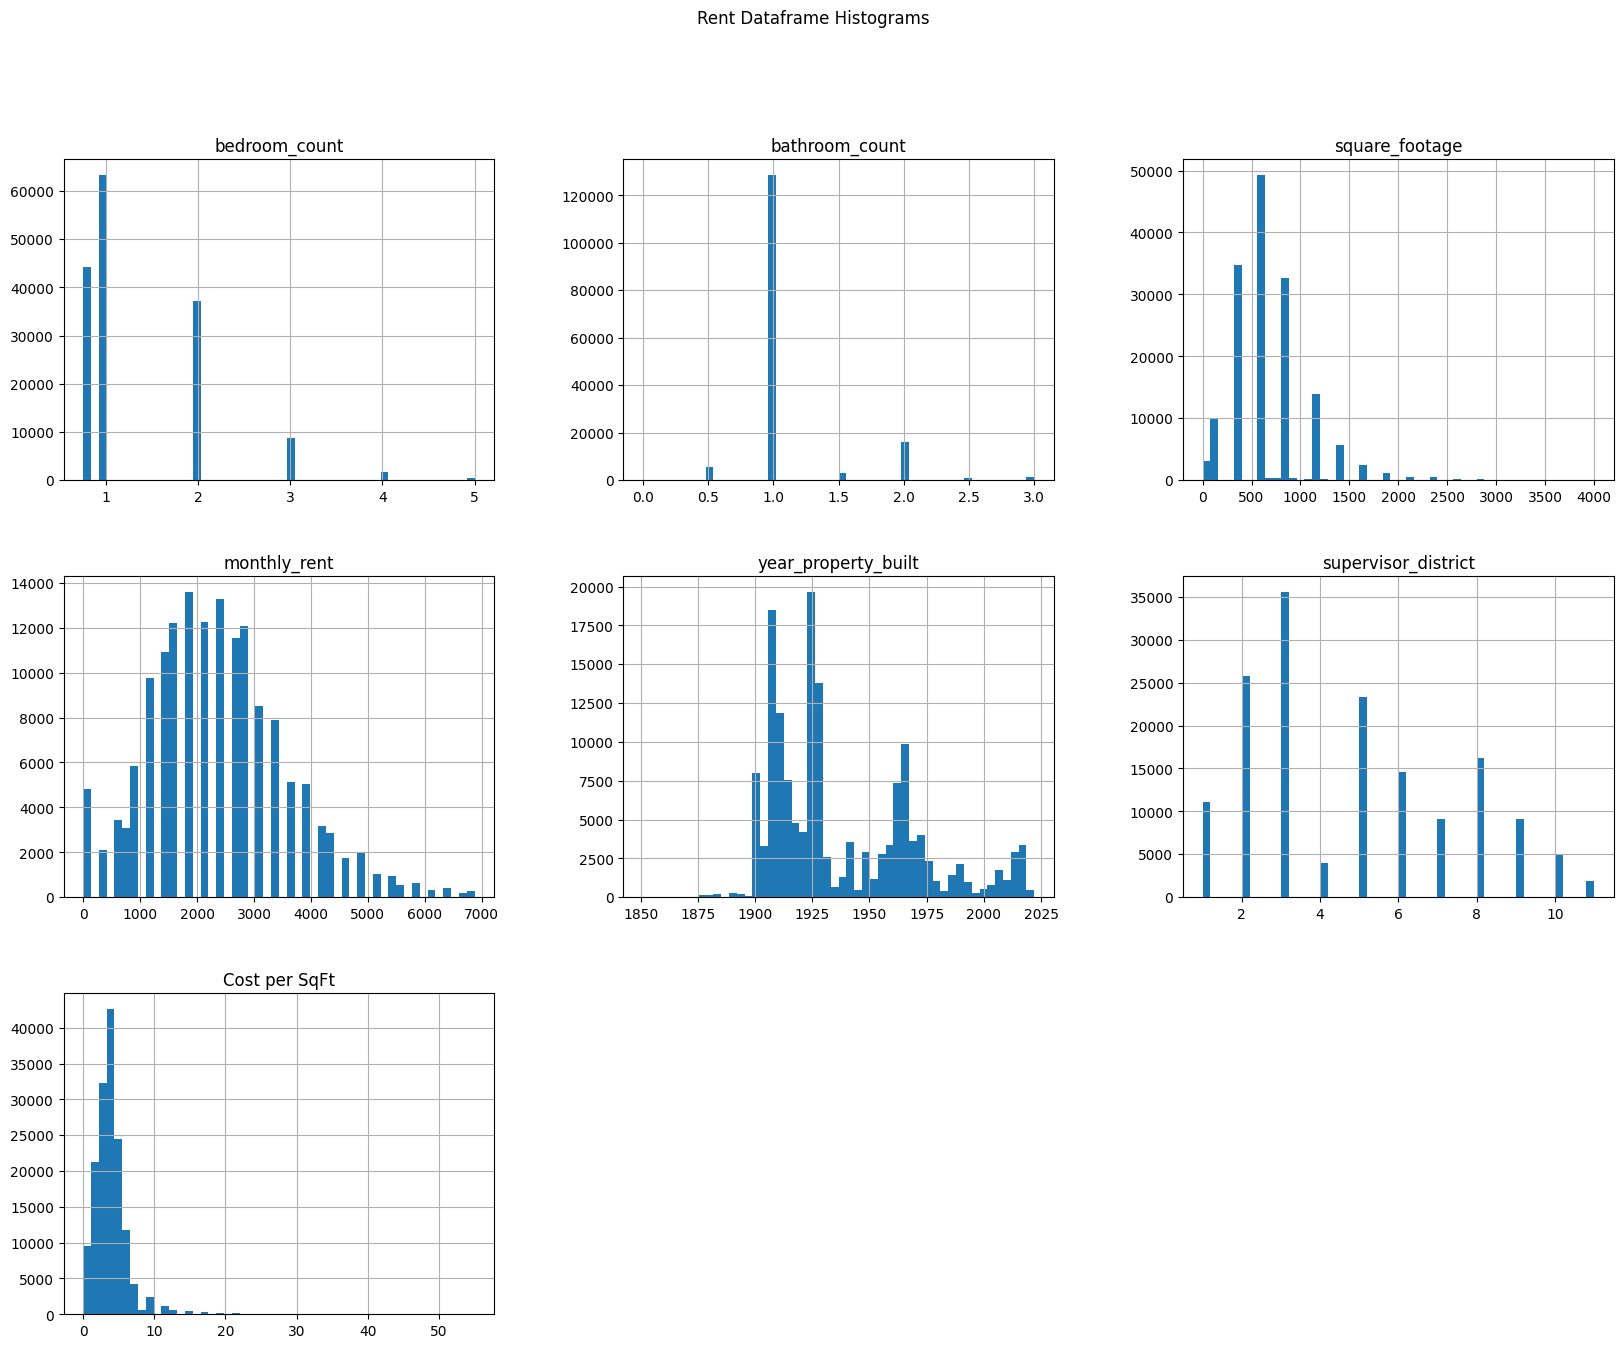

In [ ]:
##create histogram for feature distribution
rent.hist(bins = 50, figsize=(20,15))
plt.suptitle("Rent Dataframe Histograms")
plt.show()

Text(0.5, 1.0, 'Rent Dataframe Correlation Matrix')

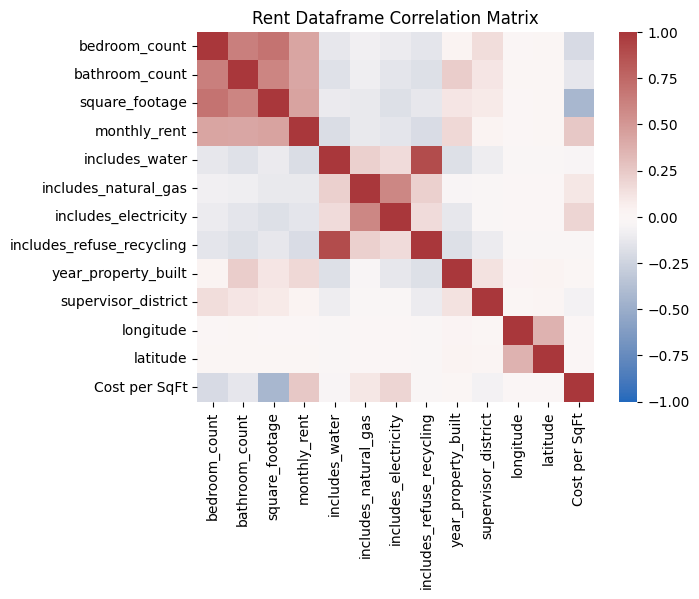

In [ ]:
#create correlation matrix
rentNum = rent.drop(columns={"analysis_neighborhood"})
corr_matrix = rentNum.corr()

sns.heatmap(corr_matrix,
            cmap="vlag",
            vmax=1,
            vmin=-1,
            fmt="s")
plt.title("Rent Dataframe Correlation Matrix")

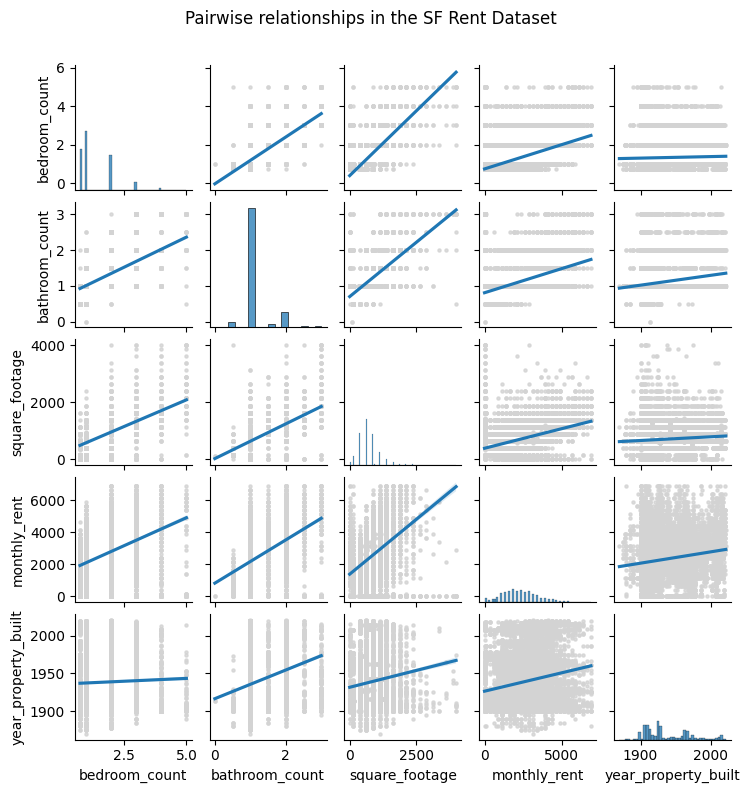

<Figure size 640x480 with 0 Axes>

In [ ]:
numeric_cols = [
    'bedroom_count', 'bathroom_count', 'square_footage',
    'monthly_rent', 'year_property_built'
]

# Create the pairplot
g = sns.pairplot(
    data=rent[numeric_cols].sample(20000),
    kind="reg",  # regression lines
    plot_kws={"scatter_kws": {"color": "lightgrey", "s": 5}},
    height=1.5  # make the individual plots small
)

# Add a title
g.fig.suptitle(
    "Pairwise relationships in the SF Rent Dataset", y=1.05
)

plt.show()
plt.tight_layout()

In [ ]:
##remove outliers based on histagram
rent = rent[rent['monthly_rent'] > 500]
rent = rent[rent['monthly_rent'] < 5000]
rent = rent[rent["square_footage"] != 0]
rent = rent[rent["square_footage"] < 1500]
rent = rent[rent["bedroom_count"] < 4]

##drop unnecessary columns
rent = rent.drop(columns="Cost per SqFt", axis=1)
rent = rent.drop(["longitude", "latitude"], axis=1)

# Five Questions

# Question 1
How does location contribute to the overall renting price?

Supervisor districts 3 and 5 are the most affordable on average while districts 2, 6, and 10 are the most expensive. Chinatown, Nob Hill, and Downtown/Civic Centre see most of their rent distibution on the lowest end of the range. Russian Hill, South of Market, and Bernal Heights see a very even distribution of all price ranges. Marina, Potrero Hill, Financial District and Golden Gate Park areas have very little distribution on the affordable end of the rent scale.

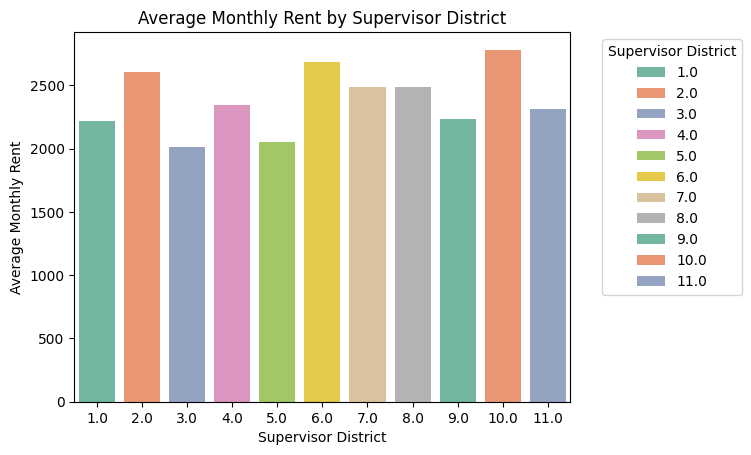

In [ ]:
#create bar plot
sns.barplot(
    data=rent,
    x='supervisor_district',
    y='monthly_rent',
    estimator = 'mean',
    errorbar = None, # removes the confidence interval lines
    palette = 'Set2',
    hue = 'supervisor_district'
)

# move the legend
plt.legend(
    title='Supervisor District',
    bbox_to_anchor=(1.05, 1),  # moves it outside the plot
    loc='upper left'
)

plt.title('Average Monthly Rent by Supervisor District')
plt.xlabel('Supervisor District')
plt.ylabel('Average Monthly Rent')
plt.show()

Text(0.5, 1.01, 'Neighborhood Rent Distribution by Supervisor District')

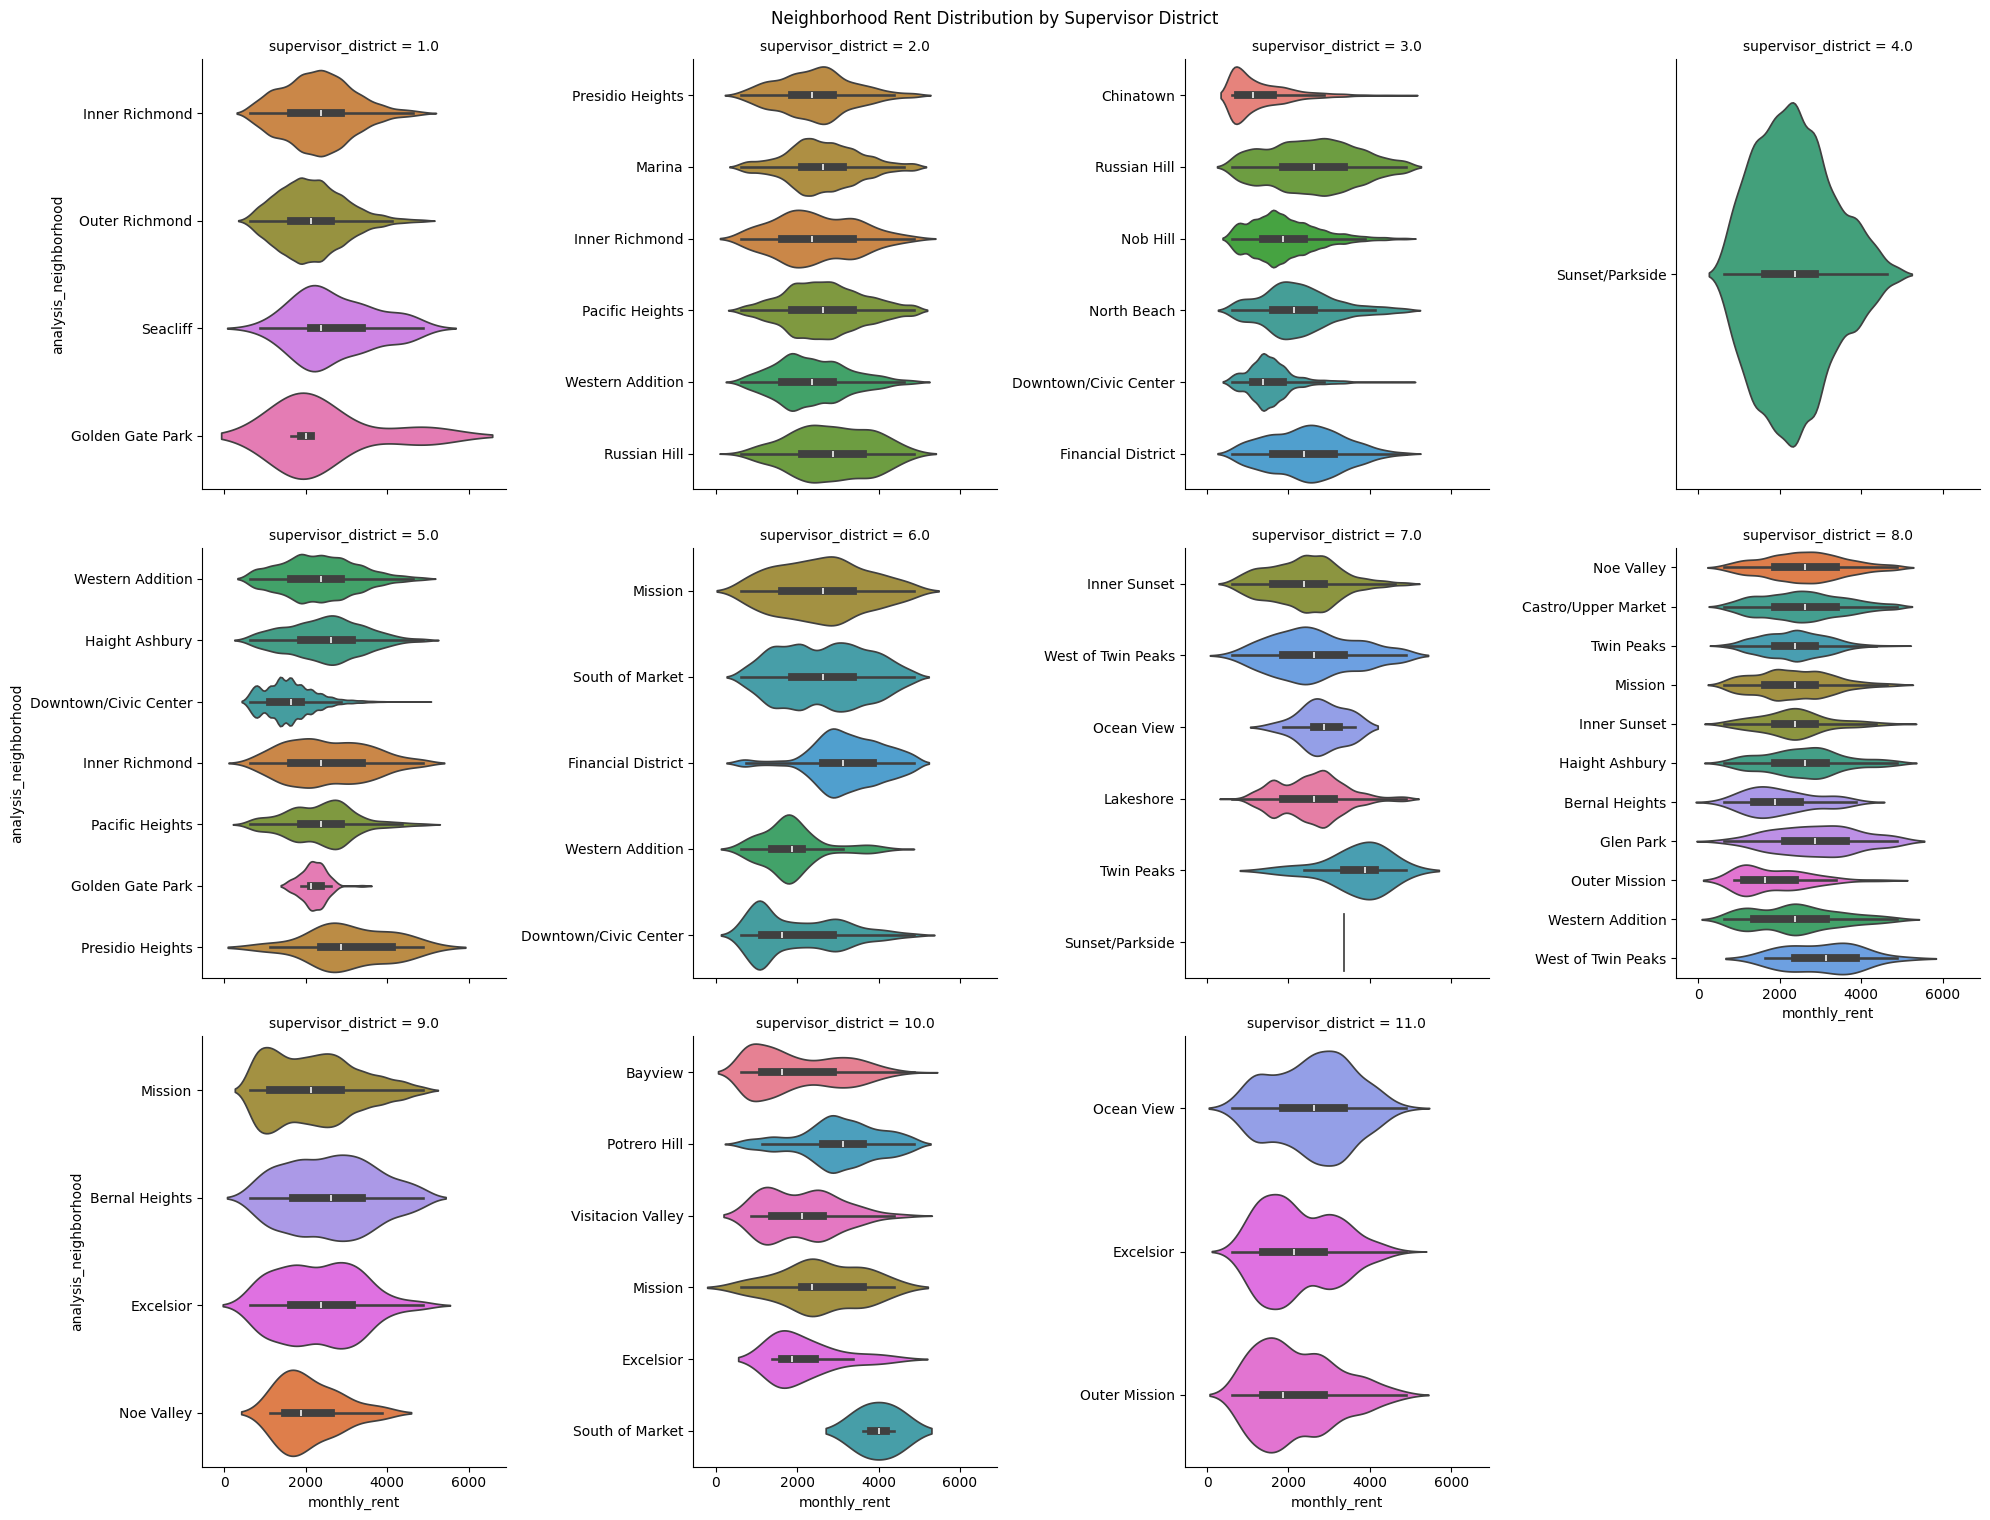

In [ ]:
##create violin plot of rent by neighborhood
g = sns.catplot(rent,
            y = 'analysis_neighborhood',
            x = 'monthly_rent',
            kind = 'violin',
            hue = 'analysis_neighborhood',
            palette = 'husl',
            col="supervisor_district",
            col_wrap=4,
            sharey = False)
g.fig.set_size_inches(20, 15)
g.fig.suptitle('Neighborhood Rent Distribution by Supervisor District', y=1.01)

# Question 2`




Which neighborhood has the most amount of old apartment buildings built in 1886 and before?

Western Addition and Mission have the most old buildings built before 1887.

Text(0.5, 1.02, 'Neighborhoods with Property Built Before 1887')

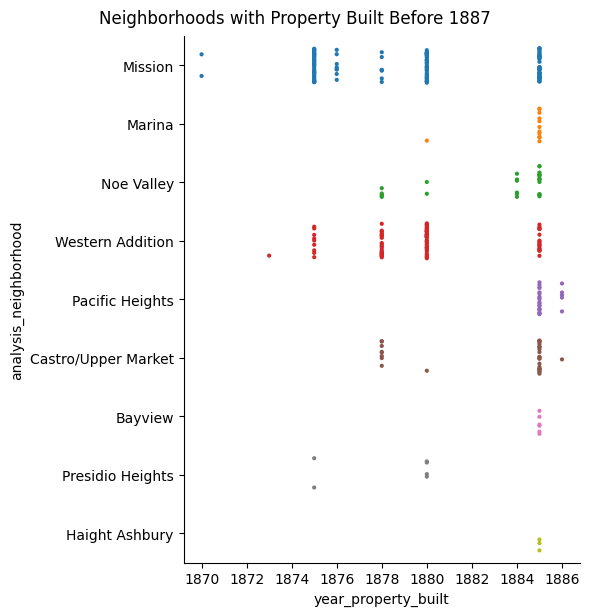

In [ ]:
##create strip plot of property build year
g = sns.catplot(rent[rent['year_property_built'] <= 1886],
            x = 'year_property_built',
            y = 'analysis_neighborhood',
            aspect = 1,
            jitter = 0.3,
            hue = 'analysis_neighborhood',
            height = 6,
            size = 3)
g.fig.suptitle('Neighborhoods with Property Built Before 1887', y=1.02)

# Question 3

How does the number of bedrooms affect the monthly rent?

As the bedroom count increases, the average monthly rent increases. There is a larger increase from studio to one bedroom and one bedroom to two, but a small increase from two bedrooms to three.

Text(0.5, 1.01, 'Monthly Rent by Bedroom Count Distribution')

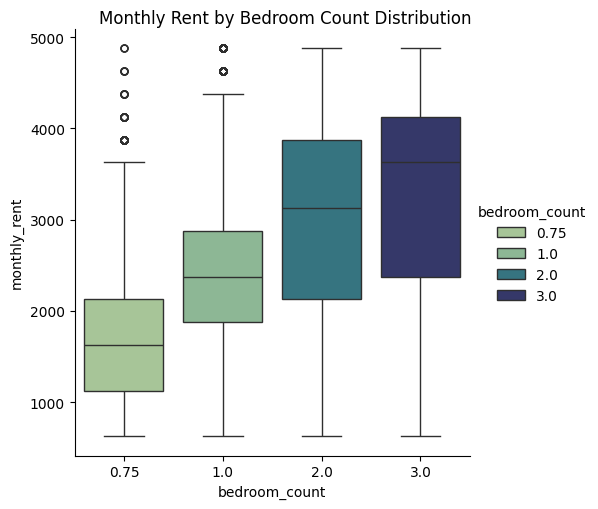

In [ ]:
#create box plot of bedroom count and rent cost
g = sns.catplot(rent,
            x = 'bedroom_count',
            y = 'monthly_rent',
            kind = 'box',
            hue = 'bedroom_count',
            palette = 'crest')
g.fig.suptitle('Monthly Rent by Bedroom Count Distribution', y=1.01)

#Question 4

Which factor has the biggest impact on the monthly rent?

Square footage has the largest positive impact on monthly rent while includes natural gas and includes refuse recycling has the largest negative impact on monthly rent.

Text(0.5, 1.0, 'Monthy Rent Correlation Matrix')

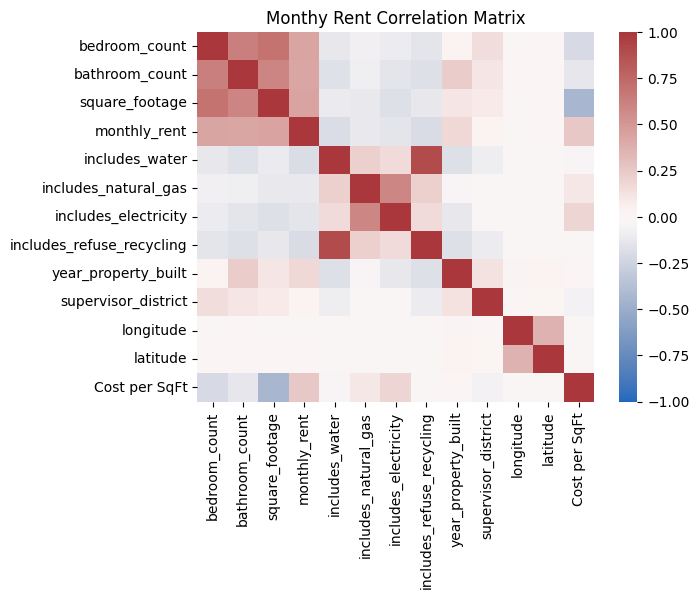

In [ ]:
#create correlation matrix to show what influences rent
sns.heatmap(corr_matrix,
            cmap="vlag",
            vmax=1,
            vmin=-1)
plt.title('Monthy Rent Correlation Matrix')

#Question 5
How does the average rent and other price-affecting elements differ among neighborhoods?

The financial district, potero hill, and glen park have the highest average rents of all neighborhoods. Among those, the Financial District has the smallest average square footage making it the worst value neighborhood. Chinatown and downtown/civic center have the lowest average rents but also a very low average square footage, making them a compromise not suited to all renters. The next lowest rent regions are Outer Richmond, Vistacon Valley, and Bayview. Of these, Bayview has the lowest average rent and the highest average square footage making it the best value.

In [ ]:
##add features to geojson
for feature in data["features"]:
  mean_sqft = rent[rent['analysis_neighborhood'] == neighborhood].square_footage.mean()
  feature['properties']['square_footage'] = int(mean_sqft)

  mean_bedroom = rent[rent['analysis_neighborhood'] == neighborhood].bedroom_count.mean()
  feature['properties']['bedroom'] = int(mean_bedroom)

  sup_district = rent[rent['analysis_neighborhood'] == neighborhood].supervisor_district.mean()
  feature['properties']['supervisor_district'] = int(sup_district)

In [ ]:
##map choropleth of rent
SF_map = folium.Map(location=[37.7749, -122.4194], zoom_start=13)

choro = folium.Choropleth(
    geo_data=data,
    name='Choropleth',
    data = wide.mean(),
    columns=['analysis_neighborhood','monthly_rent'],
    key_on='feature.properties.name',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Average Rent in SF',
).add_to(SF_map)

##add tooltips
folium.GeoJson(
    data,
    tooltip=folium.GeoJsonTooltip(fields=['name', 'rent', 'square_footage', 'bedroom', 'supervisor_district'],
                                  aliases=['Region Name:', "Average Rent:", "Average Sq.Ft:", "Average # of Bedrooms:", "Supervisor District:"])
).add_to(SF_map)


SF_map

# Machine Learning

# Prep


In [ ]:
##ml imports
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

<Axes: >

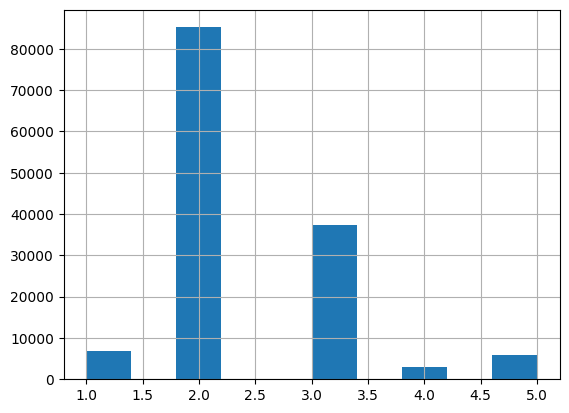

In [ ]:
##divide years into bins
rent["year-bin"] = pd.cut(rent["year_property_built"],
                                       bins=[1800, 1900, 1950, 2000, 2010, np.inf],
                                       labels=[1, 2, 3, 4, 5])

rent["year-bin"].hist()

In [ ]:
# Stratified split based on year bins
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

##create training and test sets
for train_index, test_index in split.split(rent, rent["year-bin"]):
    strat_train_set = rent.iloc[train_index]  # Use iloc instead of loc
    strat_test_set = rent.iloc[test_index]


In [ ]:
##drop the year bin column
for set_ in (strat_train_set, strat_test_set):
    set_.drop("year-bin", axis=1, inplace=True)

<ipython-input-175-575630a34de1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("year-bin", axis=1, inplace=True)
<ipython-input-175-575630a34de1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("year-bin", axis=1, inplace=True)


In [ ]:
strat_train_set.head()

,bedroom_count,bathroom_count,square_footage,monthly_rent,includes_water,includes_natural_gas,includes_electricity,includes_refuse_recycling,year_property_built,analysis_neighborhood,supervisor_district
39289,0.75,1.0,375.5,1625.5,True,False,False,True,1929.0,Pacific Heights,2.0
84770,0.75,1.0,375.5,2125.5,True,False,False,True,1968.0,Western Addition,2.0
147354,0.75,0.5,125.0,1125.5,True,True,True,True,1907.0,Nob Hill,3.0
135534,0.75,1.0,125.0,1375.5,True,True,False,True,1908.0,Downtown/Civic Center,5.0
71505,1.00,1.0,875.5,3875.5,True,True,True,True,1923.0,Pacific Heights,2.0


In [ ]:
##create and execute pipeline to prepare for models
rent_cat = rent[["analysis_neighborhood"]]
rent = strat_train_set.drop("monthly_rent", axis=1)
rent_labels = strat_train_set["monthly_rent"].copy()

# convert categorical values into one-hot vectors
cat_encoder = OneHotEncoder()
rent_cat_1hot = cat_encoder.fit_transform(rent_cat)
rent_cat_1hot

cat_attr = ["analysis_neighborhood"]
rent_num = rent.drop('analysis_neighborhood', axis=1)
num_attr = list(rent_num)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
    ])

rent_num_tr = num_pipeline.fit_transform(rent_num)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attr),
        ("cat", OneHotEncoder(), cat_attr)
    ])

rent_prepared = full_pipeline.fit_transform(rent)
cols=list(rent_num) + cat_encoder.categories_[0].tolist()

## Convert the 2D array into Pandas DataFrame
rent_prep_df = pd.DataFrame.sparse.from_spmatrix(
    rent_prepared,
    columns=cols,
    index=rent.index)
rent_prep_df.head()

,bedroom_count,bathroom_count,square_footage,includes_water,includes_natural_gas,includes_electricity,includes_refuse_recycling,year_property_built,supervisor_district,Bayview,...,Potrero Hill,Presidio Heights,Russian Hill,Seacliff,South of Market,Sunset/Parkside,Twin Peaks,Visitacion Valley,West of Twin Peaks,Western Addition
39289,-0.81379,-0.253473,-0.980238,0.738006,-0.364447,-0.277366,0.730458,-0.278178,-1.026906,0,...,0,0,0,0,0,0,0,0,0,0
84770,-0.81379,-0.253473,-0.980238,0.738006,-0.364447,-0.277366,0.730458,0.96322,-1.026906,0,...,0,0,0,0,0,0,0,0,0,1.0
147354,-0.81379,-1.893586,-1.854951,0.738006,2.743885,3.605348,0.730458,-0.978454,-0.643032,0,...,0,0,0,0,0,0,0,0,0,0
135534,-0.81379,-0.253473,-1.854951,0.738006,2.743885,-0.277366,0.730458,-0.946623,0.124718,0,...,0,0,0,0,0,0,0,0,0,0
71505,-0.385845,-0.253473,0.765697,0.738006,2.743885,3.605348,0.730458,-0.469162,-1.026906,0,...,0,0,0,0,0,0,0,0,0,0


# Model One - Linear Regression

In [ ]:
# train a linear regression model with our housing_prepared training data
lin_reg = LinearRegression()
lin_reg.fit(rent_prepared, rent_labels)

LinearRegression()

In [ ]:
##get scores of linreg
rent_predictions = lin_reg.predict(rent_prepared)

lin_mse = mean_squared_error(rent_labels, rent_predictions)
lin_rmse = np.sqrt(lin_mse)
print("lin_rmse:", lin_rmse)

lin_mae = mean_absolute_error(rent_labels, rent_predictions)
print("lin_mae:", lin_mae)

lin_rmse: 747.7438697330874
lin_mae: 581.1513781762377



# Model Two - Decision Tree

In [ ]:
#train decision tree model
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(rent_prepared, rent_labels)

rent_predictions = tree_reg.predict(rent_prepared)
tree_mse = mean_squared_error(rent_labels, rent_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(533.6153929477983)

# Model Three - Random Forest Regression

In [ ]:
##train random forest model
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(rent_prepared, rent_labels)
rent_predictions = forest_reg.predict(rent_prepared)
forest_mse = mean_squared_error(rent_labels, rent_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(545.3242233859772)

# Scores

In [ ]:
##formatting to print scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
##score decision tree
scores = cross_val_score(tree_reg, rent_prepared, rent_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

print("RMSE")
display_scores(tree_rmse_scores)

scores = cross_val_score(tree_reg, rent_prepared, rent_labels,
                        scoring="neg_mean_absolute_error", cv=10)
print("MAE")
display_scores(-scores)

RMSE
Scores: [661.29514971 654.41399912 649.02835319 662.22623293 672.49630586
 655.68850703 666.13194649 657.94893407 655.2855039  654.36828596]
Mean: 658.8883218269895
Standard deviation: 6.452539260783997
MAE
Scores: [468.53480388 462.16617648 459.8717936  466.29171052 474.61205403
 465.30680179 471.44377037 467.32864971 464.48222737 460.23551595]
Mean: 466.0273503689144
Standard deviation: 4.475900090296533


In [ ]:
##score linear regression
lin_scores = cross_val_score(lin_reg, rent_prepared, rent_labels,
                        scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print("RMSE")
display_scores(lin_rmse_scores)

scores = cross_val_score(lin_reg, rent_prepared, rent_labels,
                        scoring="neg_mean_absolute_error", cv=10)
print("MAE")
display_scores(-scores)

RMSE
Scores: [750.97350333 744.79647179 753.07115256 743.75211787 750.18171668
 744.57905401 751.71642447 747.84551748 752.3226678  740.75380755]
Mean: 747.9992433553441
Standard deviation: 4.054091722505182
MAE
Scores: [584.82822542 582.09758755 586.44101005 575.29862119 582.89851542
 579.27244052 586.09837332 581.18088062 582.88569343 572.51141871]
Mean: 581.3512766224236
Standard deviation: 4.3007344624958534


In [ ]:
##score random forest
forest_scores = cross_val_score(forest_reg, rent_prepared, rent_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print("RMSE")
display_scores(forest_rmse_scores)

scores = cross_val_score(forest_reg, rent_prepared, rent_labels,
                        scoring="neg_mean_absolute_error", cv=10)
print("MAE")
display_scores(-scores)

RMSE
Scores: [643.84413196 634.58038639 634.38165416 639.45099536 655.1127002
 635.5937007  645.26830912 640.24859762 637.91957406 630.44065142]
Mean: 639.684070099671
Standard deviation: 6.680973292303966
MAE
Scores: [468.08394616 461.78784009 461.56873583 462.50607123 474.72732856
 463.87396627 469.52521256 467.0382673  464.34350187 455.81714438]
Mean: 464.92720142375913
Standard deviation: 4.929966892969135


# Fine Tuning the Model
Since, the forest regressor model has the best results, we will analyze about it more in detail. Note: had to reduce size to 20,000 because the program was taking too long to run.

In [ ]:
#finetuning imports
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
#fine tune random forest with grid search
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_search.fit(rent_prepared, rent_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [ ]:
print(grid_search.best_estimator_)

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)


In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

659.7756708746631 {'max_features': 2, 'n_estimators': 3}
643.7150075843812 {'max_features': 2, 'n_estimators': 10}
639.0682535172222 {'max_features': 2, 'n_estimators': 30}
658.5307800383209 {'max_features': 4, 'n_estimators': 3}
643.4411334546818 {'max_features': 4, 'n_estimators': 10}
638.8308596820802 {'max_features': 4, 'n_estimators': 30}
659.1285169083553 {'max_features': 6, 'n_estimators': 3}
644.014478899676 {'max_features': 6, 'n_estimators': 10}
639.1206007091257 {'max_features': 6, 'n_estimators': 30}
659.6730457605249 {'max_features': 8, 'n_estimators': 3}
643.3529247578501 {'max_features': 8, 'n_estimators': 10}
638.4605338042362 {'max_features': 8, 'n_estimators': 30}
653.5764283611784 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
648.7814696364454 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
653.4578414332025 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
648.8703785511154 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

In [ ]:
##grid search score
gridPred = grid_search.best_estimator_.predict(rent_prepared)
mean_absolute_error(rent_labels, gridPred)


394.6617316914532

In [ ]:
##grid search score
np.sqrt(mean_squared_error(rent_labels, gridPred))

np.float64(541.8692670212117)

In [ ]:
##finetune random forest with random search
param_distribs = {
        'n_estimators': randint(low=1, high=50),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=5, cv=3, scoring='neg_mean_squared_error',
                                random_state=42, n_jobs=-1)

In [ ]:
rnd_search.fit(rent_prepared, rent_labels)
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

645.6388407665495 {'max_features': 7, 'n_estimators': 29}
644.7904409276948 {'max_features': 7, 'n_estimators': 43}
647.2591190084844 {'max_features': 5, 'n_estimators': 21}
647.0266565645785 {'max_features': 7, 'n_estimators': 19}
650.055934637248 {'max_features': 7, 'n_estimators': 11}


In [ ]:
#score random search
randPred = rnd_search.best_estimator_.predict(rent_prepared)
mean_absolute_error(rent_labels, randPred)


394.2730812158019

In [ ]:
#score random search
np.sqrt(mean_squared_error(rent_labels, randPred))

np.float64(541.3906888138149)

# Analyze the Best Models and Their Errors
Since, the forest regressor model has the best results, we will analyze about it more in detail

In [ ]:
##imports
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.88820971e-01, 8.94765081e-02, 1.87861121e-01, 2.94732574e-02,
       1.36316124e-02, 1.18002272e-02, 3.65480360e-02, 2.44371854e-01,
       4.93159498e-02, 4.94262371e-03, 1.45349931e-03, 3.05057889e-03,
       9.98974926e-03, 1.81090878e-02, 1.72343874e-03, 6.47778331e-03,
       8.58879727e-04, 9.41522057e-05, 3.11929976e-03, 3.32298136e-03,
       2.31290315e-03, 1.37482122e-02, 1.07938018e-02, 5.56129096e-03,
       8.63368087e-03, 2.29580145e-03, 2.58545163e-03, 8.12595539e-04,
       1.37571086e-03, 3.92393318e-03, 8.83014014e-03, 6.14942659e-03,
       1.66505416e-03, 9.41758621e-03, 1.46994618e-04, 5.73370187e-03,
       3.43019618e-03, 1.19163740e-03, 4.57153693e-04, 1.05941300e-03,
       5.43370328e-03])

In [ ]:
##assess most important features
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attr + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.2443718542685009), 'year_property_built'),
 (np.float64(0.18882097128851913), 'bedroom_count'),
 (np.float64(0.18786112065440624), 'square_footage'),
 (np.float64(0.08947650814871456), 'bathroom_count'),
 (np.float64(0.04931594980592338), 'supervisor_district'),
 (np.float64(0.03654803601001941), 'includes_refuse_recycling'),
 (np.float64(0.02947325739052938), 'includes_water'),
 (np.float64(0.01810908783512548), 'Downtown/Civic Center'),
 (np.float64(0.01374821215818517), 'Lakeshore'),
 (np.float64(0.01363161239684167), 'includes_natural_gas'),
 (np.float64(0.011800227169627186), 'includes_electricity'),
 (np.float64(0.010793801830313518), 'Marina'),
 (np.float64(0.009989749262202363), 'Chinatown'),
 (np.float64(0.00941758620669943), 'Russian Hill'),
 (np.float64(0.008830140141210073), 'Pacific Heights'),
 (np.float64(0.0086336808735726), 'Nob Hill'),
 (np.float64(0.006477783305205128), 'Financial District'),
 (np.float64(0.0061494265875441), 'Potrero Hill'),
 (np.float

In [ ]:
##run final model on test set
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("monthly_rent", axis=1)
y_test = strat_test_set["monthly_rent"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

##score rmse on test set
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

np.float64(621.5327572398161)

In [ ]:
##score mae on test set
final_mae = mean_absolute_error(y_test, final_predictions)
final_mae

455.2738240917106

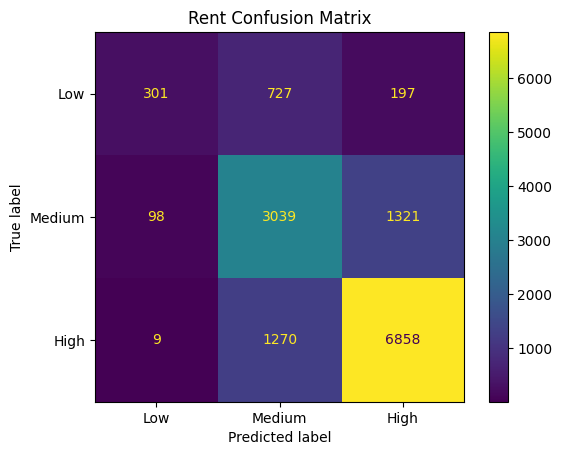

In [ ]:
# Define rent categories for confusion matrix
def categorize_rent(rent):
    if rent < 1000:
        return "Low"
    elif rent < 2000:
        return "Medium"
    else:
        return "High"

def categorize_rent2(rent):
    if rent < 1000:
        return "<1000"
    elif rent < 1500:
        return "1000-1500"
    elif rent < 2000:
        return "1500-2000"
    elif rent < 2500:
        return "2000-2500"
    elif rent < 3000:
        return "3000-3500"
    else:
        return "3500+"

# Apply categorization
y_test_cat = y_test.apply(categorize_rent)
final_predictions_cat = pd.Series(final_predictions).apply(categorize_rent)

# Create confusion matrix
cm = confusion_matrix(y_test_cat, final_predictions_cat, labels=["Low", "Medium", "High"])

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
disp.plot()
plt.title("Rent Confusion Matrix")
plt.show()

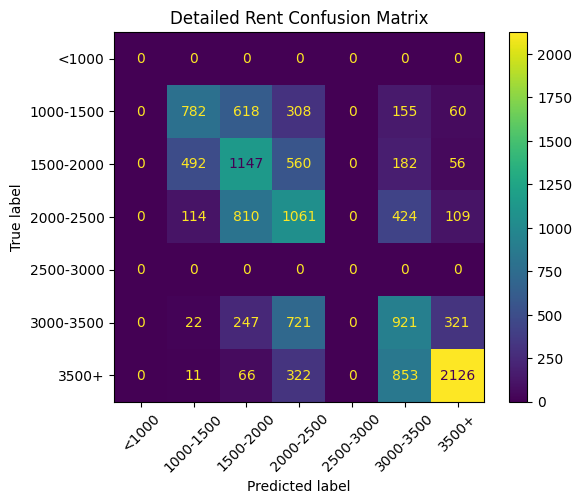

In [ ]:
# Apply detailed categorization
y_test_cat = y_test.apply(categorize_rent2)
final_predictions_cat = pd.Series(final_predictions).apply(categorize_rent2)

# Create confusion matrix
cm = confusion_matrix(y_test_cat, final_predictions_cat, labels=["high", "1000-1500", "1500-2000", "2000-2500", "2500-3000", "3000-3500", "3500+"])

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<1000", "1000-1500", "1500-2000", "2000-2500", "2500-3000", "3000-3500", "3500+"])
disp.plot()
plt.xticks(rotation=45)
plt.title("Detailed Rent Confusion Matrix")
plt.show()

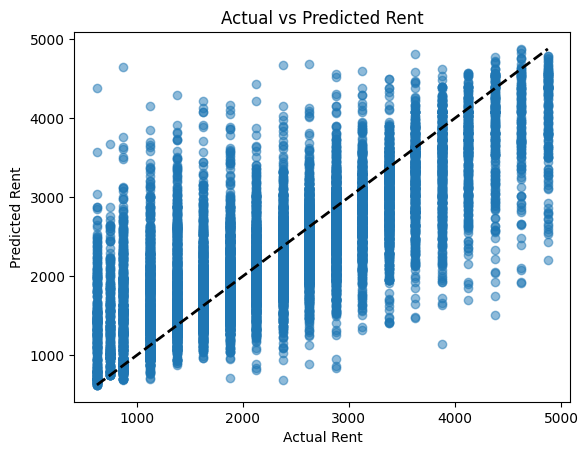

In [ ]:
#display scatter of predicted vs actual rent
plt.scatter(y_test, final_predictions, alpha=0.5)
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("Actual vs Predicted Rent")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()
